In [1]:
# Import libraries

import numpy as np
from numpy.polynomial import Polynomial

from scipy.stats import norm, pearsonr
from scipy.signal import detrend
import scipy.fft as fft
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines

import local_functions as loc
import SeaLevelContrib as slc

# For higher resolution images on retina display screens
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [17]:
# Set paths
data_altimetry_dir = '/Users/sbult/Desktop/Scripts/data/altimetry'
data_atmosphere_dir = '/Users/sbult/Desktop/Scripts/data/data_atmosphere/altimetry'

# Method to constrain the BSpline smoothing. 
# The character is only used for figures.
# m1 for constrained by degrees of freedom
# m2 for constrained by penalisation weights
method = 'm2'

# Define window in years for rate computation, should be an even number
lag = 2

In [3]:
lats = np.arange(30,71,1)
lons = np.arange(-20,21,1)
tg_id = np.zeros((len(lats),len(lons),2))

for i in range(len(lats)):
    for j in range(len(lons)):
        tg_id[i,j,:] = lats[i], lons[j]

tg_id = np.reshape(tg_id,[1681,2])

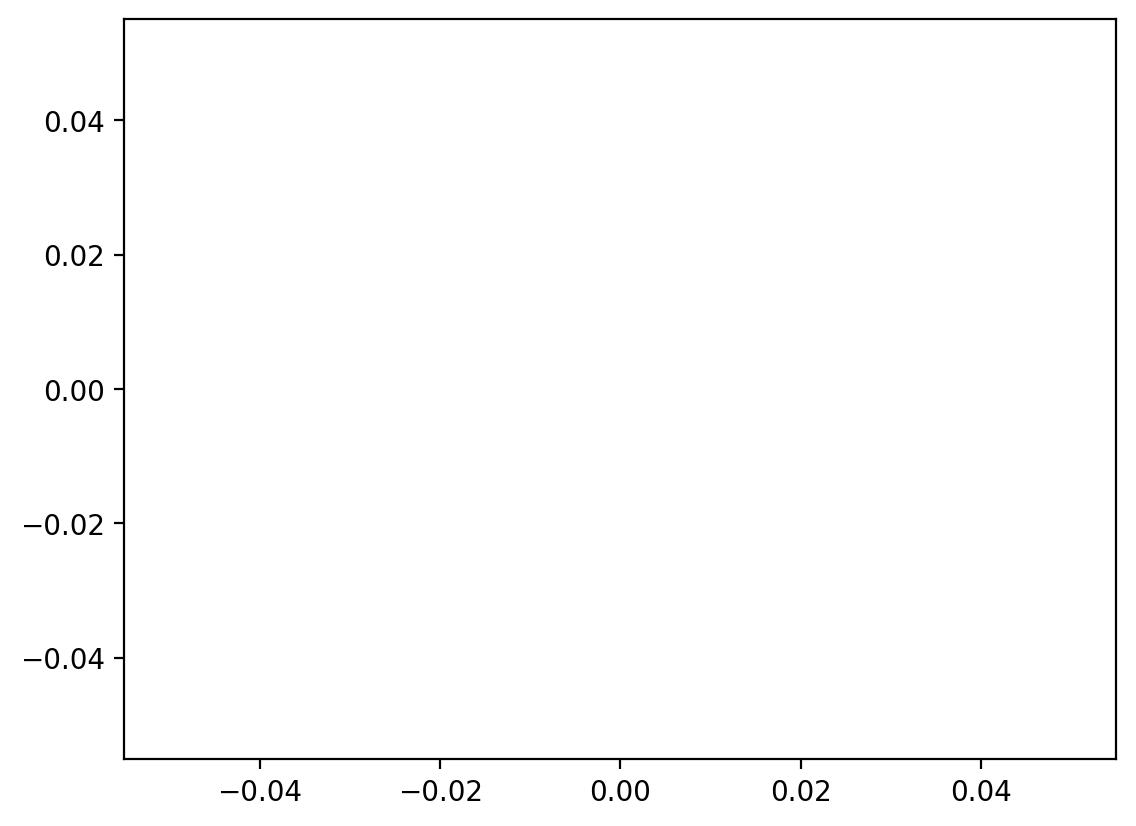

In [4]:
for i in range(len(tg_id)):
    tg_df = pd.read_csv(data_altimetry_dir + f'/datasets/altimetry_lat{tg_id[i,0]}_lon{tg_id[i,1]}.csv',index_col=0)
    tg_df.columns = ['Latitude','Longitude','Average']

plt.plot(tg_df.Average);

In [5]:
def combine_linear_scaling(d20CR, dERA5, date_s, date_e):
    
    d20CR_cor = d20CR.copy()
    
    # Substract mean of 20CR over overlapping period
    d20CR_cor = d20CR - d20CR.loc[date_s:date_e].mean()
    
    # Scale using variance
    d20CR_cor = d20CR_cor*dERA5.loc[date_s:date_e].std()/d20CR_cor.loc[date_s:date_e].std()
    
    # Substract mean of ERA5 over overlapping period
    d20CR_cor = d20CR_cor + dERA5.loc[date_s:date_e].mean()
    
    combined_df = pd.concat([d20CR_cor.loc[:1939], dERA5.loc[1940:]])
    
    return combined_df

In [6]:
def read_wind_np(lat,lon):
    '''Read wind info for the two reanalysis files and combine them'''
    
    wind_info_20CR = pd.read_csv(f'{data_atmosphere_dir}/wind_data_20CR_lat{lat}_lon{lon}.csv')
    wind_info_20CR = wind_info_20CR.set_index('t')

    wind_info_ERA5 = pd.read_csv(f'{data_atmosphere_dir}/wind_data_ERA5_lat{lat}_lon{lon}.csv')
    wind_info_ERA5 = wind_info_ERA5.set_index('t')

    combined_df = combine_linear_scaling(wind_info_20CR[['u2','v2']], wind_info_ERA5[['u2','v2']], 1950, 2015)
    
    combined_df.index.rename('time', inplace=True)
    combined_df.rename(columns = {'u2' : f'u2_{lat}_{lon}', 'v2' : f'v2_{lat}_{lon}'}, inplace=True)
    
    return combined_df

In [75]:
lat = 60
lon = -11

nearest_point_df = read_wind_np(lat,lon)
    
nearest_point_df['u2_mean'] = nearest_point_df.filter(regex='u2_').mean(axis=1)
nearest_point_df['v2_mean'] = nearest_point_df.filter(regex='v2_').mean(axis=1)

nearest_point_df

,u2_60_-11,v2_60_-11,u2_mean,v2_mean
time,,,,
1836,2.720683,-0.330634,2.720683,-0.330634
1837,3.167352,3.132393,3.167352,3.132393
1838,0.310354,6.014477,0.310354,6.014477
1839,2.009332,4.863827,2.009332,4.863827
1840,4.938290,4.474832,4.938290,4.474832
...,...,...,...,...
2018,8.011209,16.323795,8.011209,16.323795
2019,0.217095,3.788539,0.217095,3.788539
2020,16.782326,10.015389,16.782326,10.015389


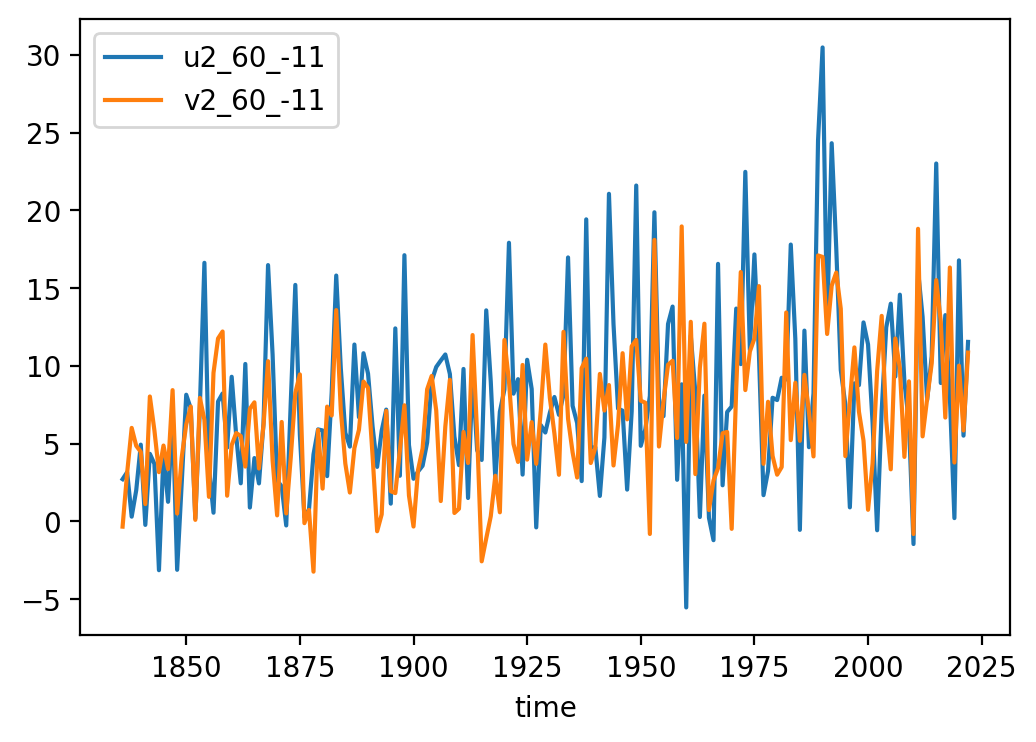

In [76]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
    
nearest_point_df[[f'u2_{lat}_{lon}',f'v2_{lat}_{lon}']].plot(ax=axes);

In [11]:
t = tg_df.index

reg_df = pd.DataFrame({'sea_level':tg_df['Average']})

reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/18.613)
reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/18.613)

reg_df = reg_df.join(nearest_point_df, how='inner')
    
reg_df['one'] = np.ones(len(reg_df.index))

reg_df

NameError: name 'nearest_point_df' is not defined

In [7]:
# Only lunar nodal tide

reg_list_nt = ['nod1', 'nod2']

regression_formula_nt = 'sea_level ~ '+' + '.join(reg_list_nt)

regression_formula_nt

'sea_level ~ nod1 + nod2'

In [8]:
# Nearest point average, including zonal and meridional wind 'NearestPointAverage2'

reg_list_na_2 = ['nod1', 'nod2', 'u2_mean', 'v2_mean']


regression_formula_na_2 = 'sea_level ~ '+' + '.join(reg_list_na_2)
    
regression_formula_na_2

'sea_level ~ nod1 + nod2 + u2_mean + v2_mean'

In [9]:
def reg_list_formula(model):
    if model == 'NoRegressor':
        reg_list = reg_list_nr
        regression_formula = regression_formula_nr
    elif model == 'NodalTide':
        reg_list = reg_list_nt
        regression_formula = regression_formula_nt  
    elif model == 'NearestPointAverage2':
        reg_list = reg_list_na_2
        regression_formula = regression_formula_na_2
        
    return reg_list, regression_formula

In [12]:
if method == 'm1':
    gam_df = 5
    gam_alpha = 0
elif method == 'm2':
    gam_df = len(t)//2
    gam_alpha = 5000

In [13]:
def gam_model(reg_df, regression_formula, summary=False):

    bs_ts = BSplines(reg_df.index, df=gam_df, degree=3) 
    # alpha is the penalization weight for smooth terms
    gam_bs_ts = GLMGam.from_formula(regression_formula, data=reg_df, smoother=bs_ts, alpha=gam_alpha)
    res_gam = gam_bs_ts.fit()

    if summary:
        print(res_gam.summary())
        
    return res_gam

In [14]:
def store_results_df(reg_df, res_gam, reg_list, model):

    # Store model results in a dataframe
    model_results_df = pd.DataFrame(index=reg_df.index)

    for proc in reg_list: 
        model_results_df[proc] = reg_df[proc]*res_gam.params[proc]

    model_results_df['trend'] = res_gam.partial_values(0, True)[0]
    model_results_df['total'] = model_results_df.sum(axis=1)

    if 'nod1' in res_gam.params.index:
        model_results_df['total_nodal'] = model_results_df['nod1'] + model_results_df['nod2']

    if model in ['NearestPointAverage', 'NearestPointAverage2']:
        model_results_df['total_wind'] = model_results_df.filter(regex='[u-v]2_').sum(axis=1)
    elif model == 'PressureDifference':
        model_results_df['total_wind'] = model_results_df.pressure_diff
    elif model == 'PressureDifference2':
        model_results_df['total_wind'] = model_results_df['pressure_north'] + model_results_df['pressure_south']
        
    return model_results_df

In [15]:
def compute_model(model, reg_df):
    
    reg_list, regression_formula = reg_list_formula(model)
    res_gam = gam_model(reg_df, regression_formula, summary=False)
    model_results_df = store_results_df(reg_df, res_gam, reg_list, model)
    
    return model_results_df, res_gam

In [85]:
res_nt, res_full_nt = compute_model('NodalTide', reg_df)

In [86]:
res_na_2, res_full_na_2 = compute_model('NearestPointAverage2', reg_df)

In [87]:
model_list = ['NodalTide','NearestPointAverage2']

In [88]:
for idx, df in enumerate([res_nt,res_na_2]):
    df.to_csv(f'/Users/sbult/Desktop/Scripts/data/altimetry/output/results_{lat}_{lon}_{model_list[idx]}.csv')

In [20]:
for i in range(len(tg_id)):
    tg_df = pd.read_csv(data_altimetry_dir + f'/datasets/altimetry_lat{tg_id[i,0]}_lon{tg_id[i,1]}.csv',index_col=0)
    tg_df.columns = ['Latitude','Longitude','Average']
    
    if tg_df['Average'].isnull().any() == False:
    
        lat = tg_id[i,0]
        lon = tg_id[i,1]
    
        nearest_point_df = read_wind_np(lat,lon)
    
        nearest_point_df['u2_mean'] = nearest_point_df.filter(regex='u2_').mean(axis=1)
        nearest_point_df['v2_mean'] = nearest_point_df.filter(regex='v2_').mean(axis=1)
    
        t = tg_df.index

        reg_df = pd.DataFrame({'sea_level':tg_df['Average']})

        reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/18.613)
        reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/18.613)

        reg_df = reg_df.join(nearest_point_df, how='inner')
    
        reg_df['one'] = np.ones(len(reg_df.index))

        res_nt, res_full_nt = compute_model('NodalTide', reg_df)
        res_na_2, res_full_na_2 = compute_model('NearestPointAverage2', reg_df)

        model_list = ['NodalTide','NearestPointAverage2']

        for idx, df in enumerate([res_nt,res_na_2]):
            df.to_csv(f'/Users/sbult/Desktop/Scripts/data/altimetry/output/results_{lat}_{lon}_{model_list[idx]}.csv')
    else:
        print(i)

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
260
261
266
267
268
269
270
271
272
273
274
275
276
277
298
299
300
301
302
303
304
305
310
311
312
313
314
315
316
317
318
320
321
322
339
340
341
342
343
344
345
346
347
348
361
362
363
364
380
381
382
383
384
385
386
387
388
389
392
398
405
406
421
422
423
424
425
426
427
428
429
430
433
439
440
445
446
447
448
462
463
464
465
466
467
468
469
470
471
472
473
480
481
484
485
486
487
488
489
503
504
505
506
507
508
509
510
511
512
513
514
515
521
523
524
525
526
527
528
530
531
532